# Cohort Analysis, RFM segmentation and customer clustering

We will do data cleaning, Explorartory analysis which inlcudes Cohort Analysis, RFM segmentation and customer clustering using clustering algorithms on online retail dataset.
Online retail dataset is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
	

### Import data
Data is provided in excel file which we need to import in dataframe for further analysis and model building

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix
from sklearn.cluster import AgglomerativeClustering

In [2]:
# read excel file into dataframe
df = pd.read_excel('Online Retail.xlsx')

In [3]:
# 5 records of datframe
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides. 

### Data cleaning
Data for analysis should be clean. Thus need to clean data to right insights. Data cleaning  includes removing NA values, useless columns, storing data in right data types and deriving new columns.

In [4]:
# shape of df before cleaning 
df.shape

(541909, 8)

In [5]:
# checking null values in df
missing_df = df.isnull()

In [6]:
# column wise null values
for col in missing_df.columns:
    print(missing_df[col].value_counts(),'\n')

False    541909
Name: InvoiceNo, dtype: int64 

False    541909
Name: StockCode, dtype: int64 

False    540455
True       1454
Name: Description, dtype: int64 

False    541909
Name: Quantity, dtype: int64 

False    541909
Name: InvoiceDate, dtype: int64 

False    541909
Name: UnitPrice, dtype: int64 

False    406829
True     135080
Name: CustomerID, dtype: int64 

False    541909
Name: Country, dtype: int64 



In [7]:
# drop rows where customer id is null
df.dropna(subset=['CustomerID'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.shape

(406829, 8)

In [9]:
## check for duplicates transactions (entries)
df[df.duplicated(keep='first')].head(10)           #5225
df.duplicated().sum()

5225

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape                            #406829-5225

(401604, 8)

In [12]:
# statistical summary fro all types of variables i.e numeric and categorical
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,401604.0,401604,401604,401604.000000,401604,401604.000000,401604.000000,401604
unique,22190.0,3684,3896,NaN,20460,NaN,NaN,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom
freq,542.0,2065,2058,NaN,543,NaN,NaN,356728
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.183273,NaN,3.474064,15281.160818,NaN
std,NaN,NaN,NaN,250.283037,NaN,69.764035,1714.006089,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13939.000000,NaN


In [13]:
# check for invoice number
# InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. 
# If this code starts with letter 'c', it indicates a cancellation.
df['cancelled_order'] = df['InvoiceNo'].apply(lambda x : int('C' in str(x)))

In [14]:
df['cancelled_order'].value_counts()

0    392732
1      8872
Name: cancelled_order, dtype: int64

In [15]:
nocancel_df = df[df['cancelled_order']==0]
cancel_df = df[df['cancelled_order']==1]

In [16]:
print(nocancel_df.shape)
print(cancel_df.shape)
print(df.shape)

(392732, 9)
(8872, 9)
(401604, 9)


In [17]:
# StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
# check for data where stockcode is not int
df['InValidStock']= df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)

In [18]:
# storing invalid stockcodes in the list
invalid_stocks = df[df['InValidStock']==True]['StockCode'].unique().tolist()
invalid_stocks 

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

In [19]:
# checking rows which have invalid stockcodes
df[df['StockCode'].isin(invalid_stocks)].count()

InvoiceNo          1915
StockCode          1915
Description        1915
Quantity           1915
InvoiceDate        1915
UnitPrice          1915
CustomerID         1915
Country            1915
cancelled_order    1915
InValidStock       1915
dtype: int64

In [20]:
# dataframe with valid stockcodes
df = df[~df['StockCode'].isin(invalid_stocks)]

In [21]:
df.shape

(399689, 10)

In [22]:
df.drop(columns=['InValidStock'], axis=1, inplace=True)

In [23]:
# shape of dataframe after cleaning
df.shape

(399689, 9)

In [24]:
# Quantity: The quantities of each product (item) per transaction. Numeric.
df[df['Quantity']<0].shape

(8506, 9)

In [25]:
# only cancelled orders have quantity in negative
df[df['Quantity']<0]['cancelled_order'].value_counts()

1    8506
Name: cancelled_order, dtype: int64

In [26]:
#UnitPrice: Unit price. Numeric, Product price per unit in sterling.
#free stuff
df[df['UnitPrice']==0].count()

InvoiceNo          33
StockCode          33
Description        33
Quantity           33
InvoiceDate        33
UnitPrice          33
CustomerID         33
Country            33
cancelled_order    33
dtype: int64

In [27]:
# deriving total price for each line item level bill
df['Total_Price'] = df['UnitPrice']*df['Quantity']

In [28]:
df[df['cancelled_order']==1].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled_order,Total_Price
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1,-6.96


### Exploratory Data Analysis
EDA involves finding insights from data. We will perfrom EDA considering KPI of retail domain such as Sales, Bills, customers shopped, quantities bought.
EDA has covered following insights:

1] Top 10 product as per sales

2] Top countries as per number of transaction

3] Cohort Analysis for customers, sales

4] Analysis of different cohorts considering retention of customers

5] Monthwise trend for following KPI of retail domain

            5.1] Total Sales
            5.2] Total Quantities bought
            5.3] Total Customers shopped
            5.4] Total bills

In [29]:
# Top selling products
product_df = df.groupby(['StockCode','Description']).agg({'Total_Price' : np.sum, 'InvoiceNo' : pd.Series.nunique, 
                                                          'Quantity' : np.sum, 'CustomerID' : pd.Series.nunique})
product_df.sort_values(by=['Total_Price', 'InvoiceNo','Quantity', 'CustomerID'], ascending=False, inplace=True)

In [30]:
product_df.head(10)

,,Total_Price,InvoiceNo,Quantity,CustomerID
StockCode,Description,,,,
22423,REGENCY CAKESTAND 3 TIER,132567.70,1884,11529,887.0
85123A,WHITE HANGING HEART T-LIGHT HOLDER,93767.80,2013,34128,858.0
85099B,JUMBO BAG RED RETROSPOT,83056.52,1643,44963,636.0
47566,PARTY BUNTING,67628.43,1399,15015,708.0
84879,ASSORTED COLOUR BIRD ORNAMENT,56331.91,1385,35215,679.0
23084,RABBIT NIGHT LIGHT,51042.84,816,27045,450.0
79321,CHILLI LIGHTS,45915.41,525,9566,205.0
22086,PAPER CHAIN KIT 50'S CHRISTMAS,41423.78,990,15138,615.0
22502,PICNIC BASKET WICKER 60 PIECES,39619.50,2,61,1.0


<Figure size 576x576 with 0 Axes>

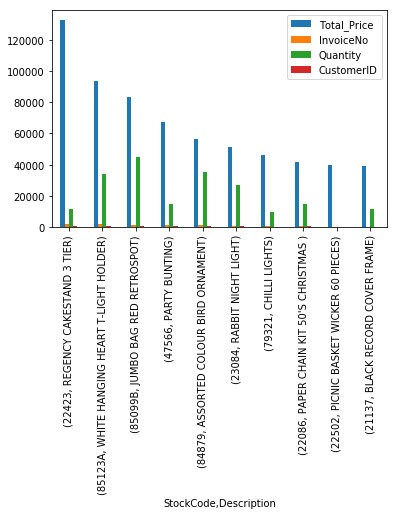

In [31]:
top_10_product = product_df.head(10)
plt.figure(figsize=(8,8))
top_10_product.plot(kind='bar')

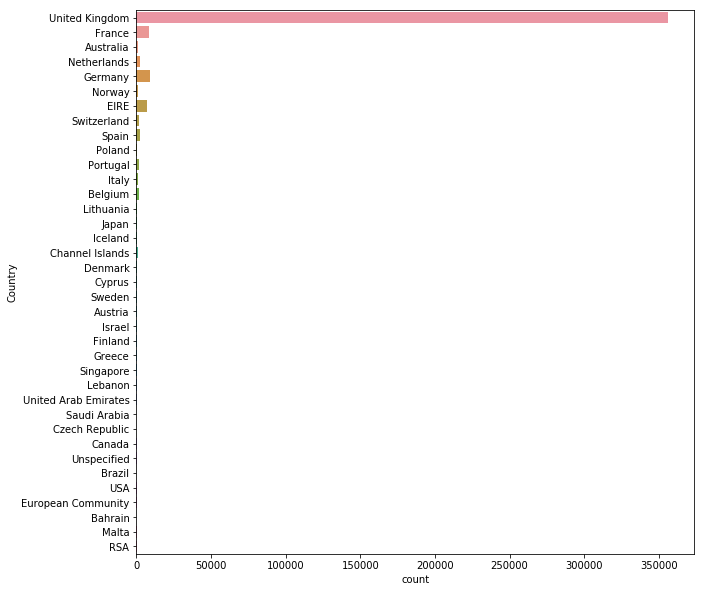

In [34]:
# Top countries as per number of transaction
# univariate analysis for categorical variables
plt.figure(figsize=(10,10))
sns.countplot(y='Country', data=df)

In [35]:
# function to return first day of every date 
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [36]:
df['Invoice_Month'] = df['InvoiceDate'].apply(get_month)

In [37]:
df.sort_values(by=['InvoiceDate'], ascending=False).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled_order,Total_Price,Invoice_Month
406828,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,0,14.85,2011-12-01
406821,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0,France,0,15.60,2011-12-01
406815,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680.0,France,0,19.80,2011-12-01
406816,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09 12:50:00,1.65,12680.0,France,0,19.80,2011-12-01
406817,581587,22728,ALARM CLOCK BAKELIKE PINK,4,2011-12-09 12:50:00,3.75,12680.0,France,0,15.00,2011-12-01


In [38]:
# grouping data by customer id
cust_grouping = df.groupby('CustomerID')['Invoice_Month']

In [39]:
# adding cohort month for each customer by taking minimum bill date
df['Cohort_Month'] = cust_grouping.transform('min')

In [40]:
# funciton to find year, moth, day of each date
def get_date_int(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [41]:
invoice_year, invoice_month, _ =  get_date_int(df, 'Invoice_Month')
cohort_year, cohort_month, _ =  get_date_int(df, 'Cohort_Month')

In [42]:
year_diff = invoice_year-cohort_year
month_diff = invoice_month-cohort_month

In [43]:
# calculating cohort index 
df['cohort_index'] = year_diff*12 + month_diff + 1

In [44]:
# checking data
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled_order,Total_Price,Invoice_Month,Cohort_Month,cohort_index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2010-12-01,2010-12-01,1


In [45]:
# grouping data by cohort month and cohort index
cust_grouping = df.groupby(['Cohort_Month','cohort_index'])

# aggregating data for sales, bills, customers, quantities
cohort_data = cust_grouping.agg({'Total_Price':np.sum, 'Quantity':np.sum, 'CustomerID':pd.Series.nunique, 
                                 'InvoiceNo':pd.Series.nunique})

In [46]:
cohort_data = cohort_data.reset_index()
cohort_data['Cohort_Month'] = cohort_data['Cohort_Month'].dt.date

In [47]:
# checking data 
cohort_data[0:10]

,Cohort_Month,cohort_index,Total_Price,Quantity,CustomerID,InvoiceNo
0,2010-12-01,1,547893.92,294770,947.0,1691
1,2010-12-01,2,269932.05,158871,360.0,683
2,2010-12-01,3,230422.51,137501,313.0,569
3,2010-12-01,4,299552.45,179610,366.0,736
4,2010-12-01,5,198777.82,130370,340.0,602
5,2010-12-01,6,326312.56,180428,376.0,791
6,2010-12-01,7,311126.08,179218,358.0,722
7,2010-12-01,8,305758.40,176432,333.0,673
8,2010-12-01,9,311477.23,199391,334.0,635
9,2010-12-01,10,465784.91,249361,373.0,780


In [48]:
# rename columns for better understanding 
cohort_data.rename(columns={'Total_Price':'Total_Sales', 'Quantity':'Total_Quantity',
                           'CustomerID':'Total_Customers', 'InvoiceNo':'Total_Invoices'}, inplace=True)

In [49]:
# pivot data for cohort analysis
cohort_count = cohort_data.pivot(index='Cohort_Month', columns='cohort_index')                 #cohort_count2

In [50]:
# explore cohort data
cohort_count

Total_Sales                                              \
cohort_index          1          2          3          4          5    
Cohort_Month                                                           
2010-12-01     547893.92  269932.05  230422.51  299552.45  198777.82   
2011-01-01     201498.29   54498.92   61528.83   40966.91   81202.24   
2011-02-01     149096.74   24690.93   37195.39   45772.52   35476.95   
2011-03-01     187365.84   26231.12   53504.30   39874.13   46746.40   
2011-04-01     117956.53   28352.75   24618.88   23742.44   25801.51   
2011-05-01     115169.87   17479.33   18648.51   17754.89   26324.20   
2011-06-01     129377.59   13100.68   13059.67   29183.39   25233.76   
2011-07-01      71781.07   10874.27   14859.92   16885.97   18454.03   
2011-08-01      76375.16   18539.38   31518.51   37701.64   13553.41   
2011-09-01     150732.53   25340.82   35267.27   12117.81        NaN   
2011-10-01     151893.88   38491.27   12144.08        NaN        NaN   
2011-11-01     131281.92   14770.00        NaN        NaN        NaN   
2011-12-01      26375.75        NaN        NaN        NaN        NaN   

                                                                     ...    \
cohort_index         6          7          8          9          10  ...     
Cohort_Month                                                         ...     
2010-12-01    326312.56  311126.08  305758.40  311477.23  465784.91  ...     
2011-01-01     82676.25   69713.45   71596.67   73823.87  103377.25  ...     
2011-02-01     30723.78   47529.60   53903.69   51520.69   59946.57  ...     
2011-03-01     38136.13   59839.42   59333.30   64536.14   11145.36  ...     
2011-04-01     28817.43   27751.02   33377.11    6057.90        NaN  ...     
2011-05-01     32316.76   30905.28   10398.87        NaN        NaN  ...     
2011-06-01     38256.02    7765.43        NaN        NaN        NaN  ...     
2011-07-01      5757.31        NaN        NaN        NaN        NaN  ...     
2011-08-01          NaN        NaN        NaN        NaN        NaN  ...     
2011-09-01          NaN        NaN        NaN        NaN        NaN  ...     
2011-10-01          NaN        NaN        NaN        NaN        NaN  ...     
2011-11-01          NaN        NaN        NaN        NaN        NaN  ...     
2011-12-01          NaN        NaN        NaN        NaN        NaN  ...     

             Total_Invoices                                                   \
cohort_index             4      5      6      7      8      9      10     11   
Cohort_Month                                                                   
2010-12-01            736.0  602.0  791.0  722.0  673.0  635.0  780.0  743.0   
2011-01-01            145.0  230.0  194.0  178.0  167.0  186.0  228.0  278.0   
2011-02-01            159.0  140.0  131.0  125.0  160.0  134.0  185.0   40.0   
2011-03-01            150.0  137.0  120.0  158.0  157.0  216.0   48.0    NaN   
2011-04-01             77.0   82.0   88.0   91.0  118.0   32.0    NaN    NaN   
2011-05-01             70.0   92.0   87.0  113.0   36.0    NaN    NaN    NaN   
2011-06-01             91.0   78.0  120.0   30.0    NaN    NaN    NaN    NaN   
2011-07-01             57.0   84.0   24.0    NaN    NaN    NaN    NaN    NaN   
2011-08-01             63.0   25.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-09-01             42.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-10-01              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                             
cohort_index      12     13  
Cohort_Month                 
2010-12-01    1118.0  390.0  
2011-01-01      89.0    NaN  
2011-02-01       NaN    NaN  
2011-03-01       NaN    NaN  
2011-04-01       NaN    NaN  
2011-05-01       NaN    NaN  
2011-06-01       NaN    NaN  
2011-07-01       NaN    NaN  


In [51]:
cohort_count_cust = cohort_count['Total_Customers']

In [52]:
# taking cohort index 1 data fro retention 
cohort_sizes = cohort_count_cust.iloc[:,0]

In [53]:
# finding retention 
retention = cohort_count_cust.divide(cohort_sizes, axis=0)

In [54]:
retention.round(3)*100

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_Month,,,,,,,,,,,,,
2010-12-01,100.0,38.0,33.1,38.6,35.9,39.7,37.8,35.2,35.3,39.4,37.3,49.9,27.3
2011-01-01,100.0,23.8,28.3,24.3,32.4,30.0,26.2,25.5,30.7,34.5,36.9,15.0,NaN
2011-02-01,100.0,24.6,19.3,28.3,27.0,24.6,25.9,27.8,25.9,31.5,9.3,NaN,NaN
2011-03-01,100.0,18.9,25.3,21.9,22.8,17.8,26.2,23.7,28.7,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.5,22.1,21.1,20.8,23.8,22.8,26.2,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.3,27.2,24.7,33.2,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,21.5,20.4,23.7,28.0,11.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,24.6,24.6,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


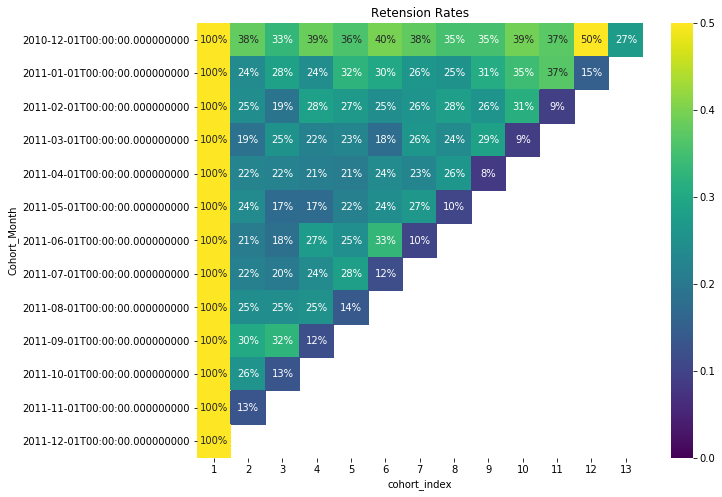

In [55]:
# visualize the retention cohort data
plt.figure(figsize=(10,8))
plt.title('Retension Rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', cmap='viridis', vmin=0.0, vmax=0.5)

In [56]:
retention

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_Month,,,,,,,,,,,,,
2010-12-01,1.0,0.380148,0.330517,0.386484,0.359029,0.397043,0.378036,0.351637,0.352693,0.393875,0.372756,0.499472,0.273495
2011-01-01,1.0,0.238095,0.283333,0.242857,0.323810,0.300000,0.261905,0.254762,0.307143,0.345238,0.369048,0.150000,NaN
2011-02-01,1.0,0.246032,0.193122,0.283069,0.269841,0.246032,0.259259,0.277778,0.259259,0.314815,0.092593,NaN,NaN
2011-03-01,1.0,0.189066,0.252847,0.218679,0.227790,0.177677,0.261959,0.236902,0.287016,0.088838,NaN,NaN,NaN
2011-04-01,1.0,0.224832,0.221477,0.211409,0.208054,0.238255,0.228188,0.261745,0.083893,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.182979,0.272340,0.246809,0.331915,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.215054,0.204301,0.236559,0.279570,0.118280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.245509,0.245509,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# data of first 3 cohort months
retention.transpose().iloc[:,:3]

Cohort_Month,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00
cohort_index,,,
1,1.000000,1.000000,1.000000
2,0.380148,0.238095,0.246032
3,0.330517,0.283333,0.193122
4,0.386484,0.242857,0.283069
5,0.359029,0.323810,0.269841
6,0.397043,0.300000,0.246032
7,0.378036,0.261905,0.259259
8,0.351637,0.254762,0.277778
9,0.352693,0.307143,0.259259


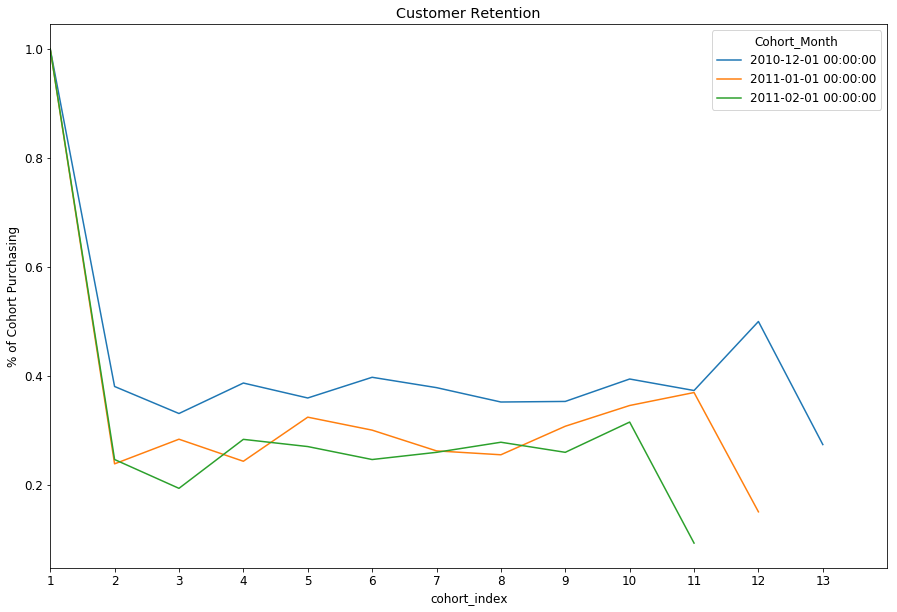

In [58]:
# Visualization of cohort index for first three cohort month
plt.rcParams['figure.figsize'] = 15, 10
plt.rcParams['font.size'] = 12
retention.transpose().iloc[:,:3].plot()
plt.title('Customer Retention')
plt.xticks(range(1, 14))
plt.xlim(1, 14)
plt.ylabel('% of Cohort Purchasing')
plt.show()

In [59]:
# transactional level analysis for all months
invoice_agg = df.groupby('Invoice_Month')

In [60]:
# aggregation of data for monthwise analysis of retail KPIs
agg_data = invoice_agg.agg({'Total_Price':np.sum, 'Quantity':np.sum, 'CustomerID':pd.Series.nunique, 
                                 'InvoiceNo':pd.Series.nunique})

In [61]:
agg_data = agg_data.reset_index()
agg_data

,Invoice_Month,Total_Price,Quantity,CustomerID,InvoiceNo
0,2010-12-01,547893.92,294770,947.0,1691
1,2011-01-01,471430.34,268512,780.0,1225
2,2011-02-01,434018.17,262230,791.0,1181
3,2011-03-01,573138.05,343792,1017.0,1588
4,2011-04-01,421127.77,277521,896.0,1358
5,2011-05-01,650314.24,368621,1076.0,1808
6,2011-06-01,640629.21,356077,1049.0,1686
7,2011-07-01,580214.73,361128,982.0,1555
8,2011-08-01,612605.13,386258,977.0,1505
9,2011-09-01,921808.74,535853,1295.0,2037


In [62]:
# rename coulmns for better understanding
agg_data.rename(columns={'Total_Price':'Total_Sales', 'Quantity':'Total_Quantity',
                           'CustomerID':'Total_Customers', 'InvoiceNo':'Total_Invoices'}, inplace=True)

In [63]:
agg_data

,Invoice_Month,Total_Sales,Total_Quantity,Total_Customers,Total_Invoices
0,2010-12-01,547893.92,294770,947.0,1691
1,2011-01-01,471430.34,268512,780.0,1225
2,2011-02-01,434018.17,262230,791.0,1181
3,2011-03-01,573138.05,343792,1017.0,1588
4,2011-04-01,421127.77,277521,896.0,1358
5,2011-05-01,650314.24,368621,1076.0,1808
6,2011-06-01,640629.21,356077,1049.0,1686
7,2011-07-01,580214.73,361128,982.0,1555
8,2011-08-01,612605.13,386258,977.0,1505
9,2011-09-01,921808.74,535853,1295.0,2037


In [64]:
agg_data['Invoice_Month'] = agg_data['Invoice_Month'].dt.date

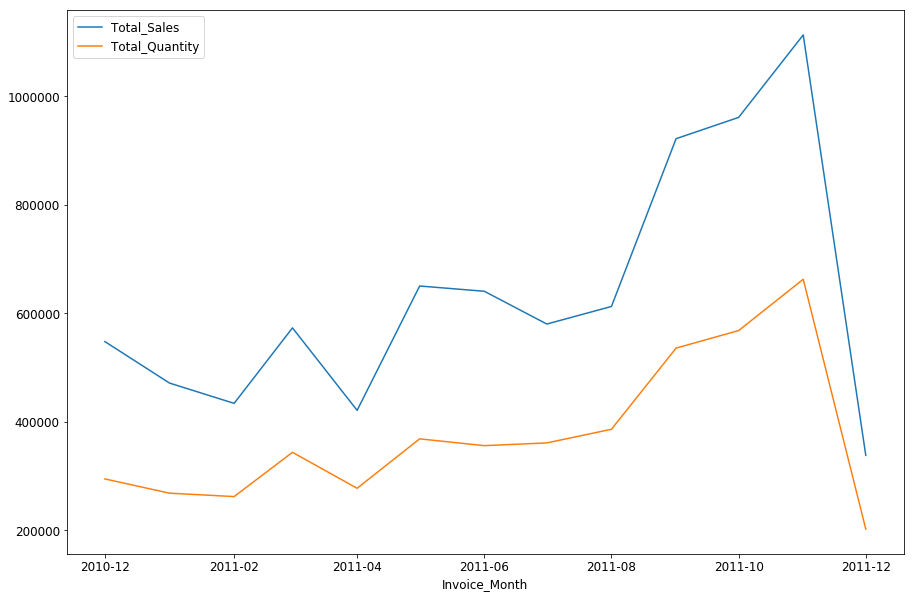

In [65]:
# monthwise trend of sales and quantities
ax = plt.gca()
agg_data.plot.line(x='Invoice_Month', y='Total_Sales', ax=ax)
agg_data.plot.line(x='Invoice_Month', y='Total_Quantity', ax=ax)
plt.show()

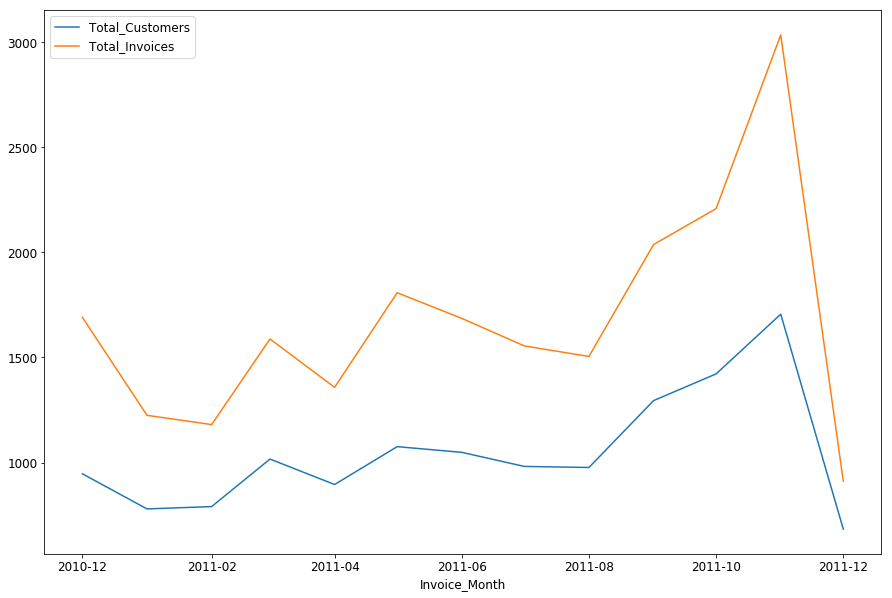

In [66]:
# monthwise trend of customers and bills
ax = plt.gca()
agg_data.plot.line(x='Invoice_Month', y='Total_Customers', ax=ax)
agg_data.plot.line(x='Invoice_Month', y='Total_Invoices', ax=ax)
plt.show()

### RFM Segmenatation
It involves behavioral segmenatation of customers as per following metrics.
* Recency - days since last customer transaction
* Frequency - number of transactions/visits in last 12 months
* Monetary - total spends in last 12 months

RFM values can be grouped in several ways.
* Percentiles e.g quantiles
* Pareto 80/20 cut
* Custom - based on business knowledge 

We are going to implement percentile-based grouping 

In [67]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled_order,Total_Price,Invoice_Month,Cohort_Month,cohort_index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2010-12-01,2010-12-01,1


In [68]:
print(min(df['InvoiceDate']), max(df['InvoiceDate']))

2010-12-01 08:26:00 2011-12-09 12:50:00


In [69]:
snapshot_date = max(df['InvoiceDate']) + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [70]:
# aggregation of data at customer level for RFM segmentation
customer_view = df.groupby(['CustomerID']).agg({'InvoiceDate':lambda x: (snapshot_date-x.max()).days, 
                                                'InvoiceNo': pd.Series.nunique, 
                                                'Total_Price': np.sum})

In [71]:
customer_view.rename(columns = {'InvoiceDate':'Recency',
                               'InvoiceNo':'Frequency',
                               'Total_Price':'Monetary'}, inplace=True)
customer_view.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1437.24
12349.0,19,1,1457.55
12350.0,310,1,294.40


In [72]:
# checking the data
customer_view.index
customer_view.loc[12820]

Recency        3.00
Frequency      4.00
Monetary     942.34
Name: 12820.0, dtype: float64

In [73]:
# Quantiles for RFM segmentation
quantiles = customer_view.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,292.175
0.50,50.0,3.0,642.320
0.75,143.0,5.0,1584.030


In [74]:
# function for recency score
def RScore(x,p,quan):
    if x<=quan[p][0.25]:
        return 4
    if x<=quan[p][0.5]:
        return 3
    if x<=quan[p][0.75]:
        return 2
    else:
        return 1   

In [75]:
# function for Frequency & monetory score
def FMScore(x,p,quan):
    if x<=quan[p][0.25]:
        return 1
    if x<=quan[p][0.5]:
        return 2
    if x<=quan[p][0.75]:
        return 3
    else:
        return 4   

In [76]:
# mapping quantiles
customer_view['R'] = customer_view['Recency'].apply(RScore,args=('Recency',quantiles,))
customer_view['F'] = customer_view['Frequency'].apply(FMScore,args=('Frequency',quantiles,))
customer_view['M'] = customer_view['Monetary'].apply(FMScore,args=('Monetary',quantiles,))

In [77]:
# counts for each RFM quantile
for col in customer_view.columns:
    if col=='R' or col=='F' or col=='M':
        print(customer_view[col].value_counts())

4    1128
1    1089
2    1074
3    1072
Name: R, dtype: int64
1    1328
2    1304
4    1067
3     664
Name: F, dtype: int64
2    1091
1    1091
4    1091
3    1090
Name: M, dtype: int64


In [78]:
# checking the data
customer_view.head(5)

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,2,1
12347.0,2,7,4310.00,4,4,4
12348.0,75,4,1437.24,2,3,3
12349.0,19,1,1457.55,3,1,3
12350.0,310,1,294.40,1,1,2


In [79]:
# function for RFM Segment
def Join_RFM(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

In [83]:
# map rfm segment
customer_view['RFM_Segment'] = customer_view.apply(Join_RFM, axis=1)

In [81]:
# map rfm score by adding values of R,F,M
customer_view['RFM_Score'] = customer_view[['R','F','M']].sum(axis=1)

In [84]:
customer_view.head(5)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,2,1,121,4
12347.0,2,7,4310.00,4,4,4,444,12
12348.0,75,4,1437.24,2,3,3,233,8
12349.0,19,1,1457.55,3,1,3,313,7
12350.0,310,1,294.40,1,1,2,112,4


In [85]:
# top 10 group as per RFM_Segment
customer_view.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:10]

RFM_Segment
444    495
111    405
344    208
112    188
211    180
122    151
223    144
222    141
311    133
212    132
dtype: int64

In [86]:
# checking data for particular segment
customer_view[customer_view['RFM_Segment']=='444'].head(5)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4310.00,4,4,4,444,12
12359.0,8,6,6182.98,4,4,4,444,12
12362.0,3,13,4665.58,4,4,4,444,12
12388.0,16,6,2780.66,4,4,4,444,12
12395.0,16,15,2662.28,4,4,4,444,12


In [87]:
# summary of Recency, freq, montory as per RFM score
customer_view.groupby('RFM_Score').agg({'Recency':np.mean, 'Frequency':np.mean, 'Monetary':[np.mean,np.size]}).round(1)

Recency Frequency Monetary       
             mean      mean     mean   size
RFM_Score                                  
3           272.8       1.0    137.4  405.0
4           187.8       1.3    258.6  485.0
5           123.2       1.6    353.8  523.0
6            90.1       1.9    527.9  500.0
7            67.7       2.6    751.3  463.0
8            52.4       3.3   1136.9  382.0
9            43.7       4.6   1369.6  394.0
10           32.8       6.1   1941.0  361.0
11           20.4       9.4   3622.0  355.0
12            6.8      18.5   8741.8  495.0

In [88]:
# grouping into named segments
def segment_customer(df):
    if df['RFM_Score']>=9:
        return '1_Gold'
    elif df['RFM_Score']>=5 and df['RFM_Score']<9:
        return '2_Silver'
    else:
        return '3_Bronze'  

In [89]:
customer_view['Segment'] = customer_view.apply(segment_customer, axis=1)

In [90]:
# summary of Recency, freq, montory as per segment
customer_view.groupby('Segment').agg({'Recency':np.mean, 'Frequency':np.mean, 'Monetary':[np.mean,np.size]}).round(1)

Recency Frequency Monetary        
            mean      mean     mean    size
Segment                                    
1_Gold      24.7      10.3   4270.0  1605.0
2_Silver    86.1       2.3    659.0  1868.0
3_Bronze   226.5       1.2    203.4   890.0

### Data Pre-processing for clustering
There are many clustering algorithms. We will implement k-means and agglomerative hierarchical clustering algorithms. We need to pre-process data to build the model.
Following assumptions are made for k-means clustering.
* Symmetric distribution of variables
* Variables with same average values
* Variables with same variance

In [91]:
# checking for skewness of variables
customer_view.skew(axis=0)

Recency         1.249975
Frequency      11.447168
Monetary       21.638900
R              -0.014008
F               0.283557
M               0.000287
RFM_Segment    -0.005786
RFM_Score       0.153899
dtype: float64

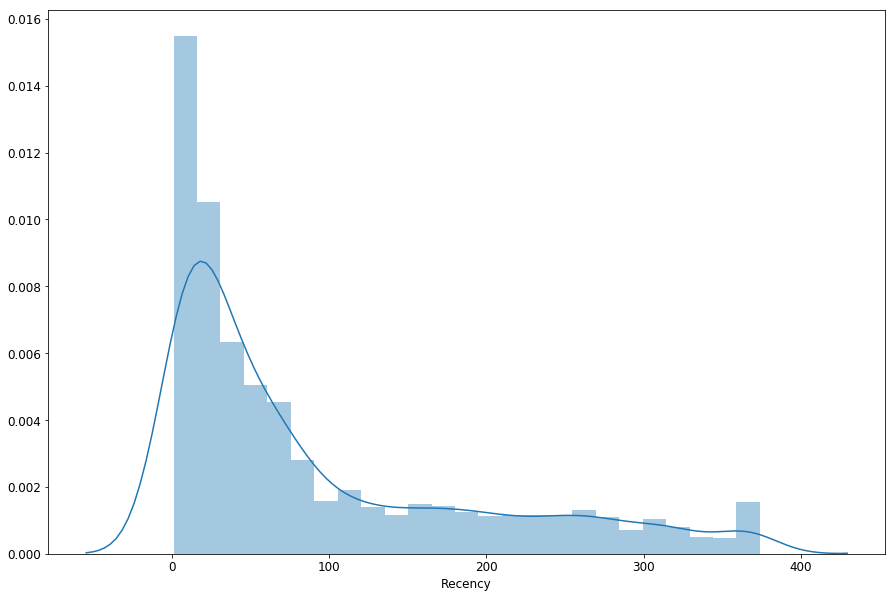

In [92]:
# checking for distribution of variables
sns.distplot(customer_view['Recency'])

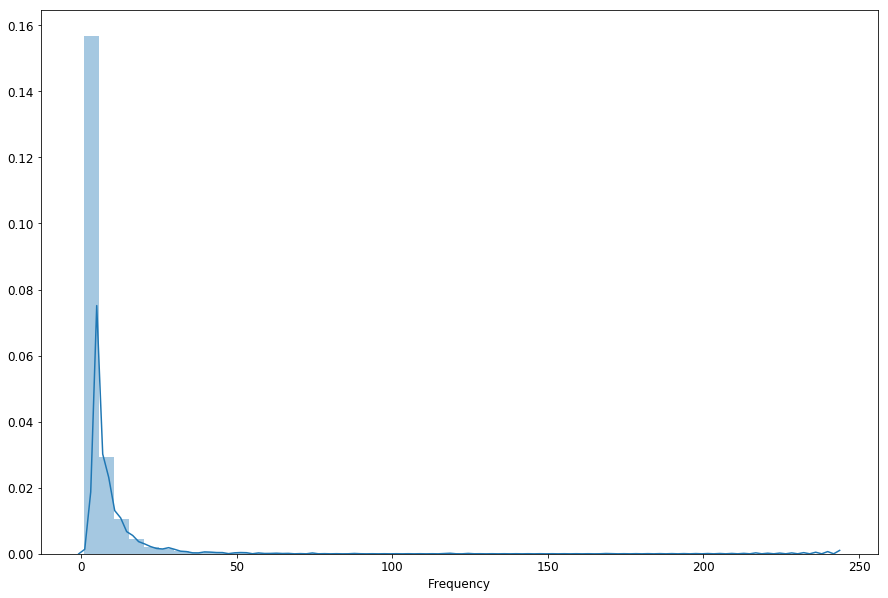

In [93]:
# checking for distribution of variables
sns.distplot(customer_view['Frequency'])

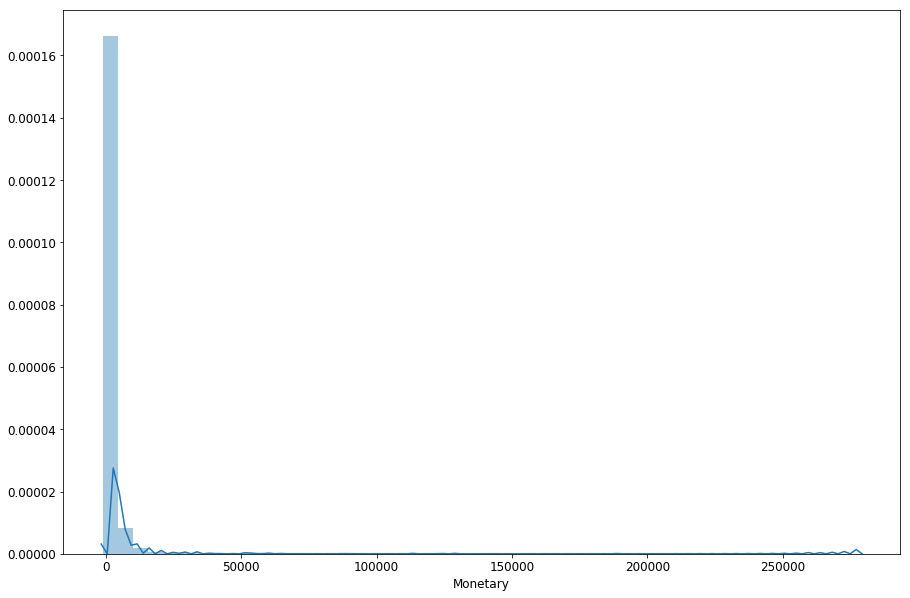

In [94]:
# checking for distribution of variables
sns.distplot(customer_view['Monetary'])

In [95]:
#normalize the data
ss = StandardScaler()
ss.fit(customer_view[['R', 'F', 'M']])
customer_view_nor = ss.transform(customer_view[['R', 'F', 'M']])

### K-Means Clustering

We are using elbow criterion to find optimal number of clusters. In this method we plot number of clusters sum of squared errors - SSE(sum of squared distances from every data point to their cluster center). We will also plot snake plot to understand and compare clusters. 

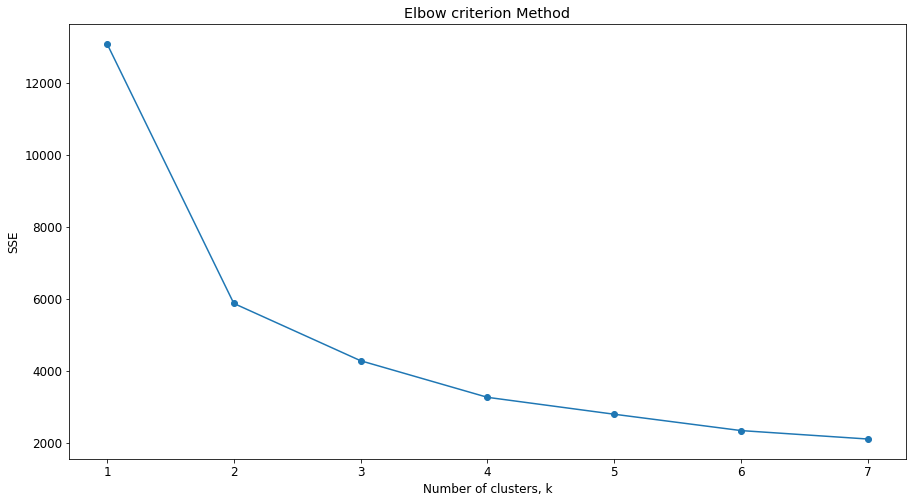

In [96]:
# Elbow criterion to get the Best KMeans 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(customer_view_nor)
    inertias.append(kc.inertia_)           #sum of squared distance to closest cluster center

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.title('Elbow criterion Method')
plt.show()

In [97]:
#choosing best model
km = KMeans(n_clusters=3)
km.fit(customer_view_nor)
customer_view['Cluster'] = km.labels_

In [98]:
# aggregated data at cluster level
customer_view.groupby(['Cluster']).agg({'Recency':np.mean,'Frequency':np.mean,'Monetary':[np.mean,np.size]}).round(0)

Recency Frequency Monetary        
           mean      mean     mean    size
Cluster                                   
0          23.0       2.0    486.0   924.0
1         181.0       2.0    444.0  1813.0
2          33.0      10.0   4312.0  1626.0

In [99]:
# data preparation for snake plot
customer_view_nor = pd.DataFrame(customer_view_nor,index=customer_view.index,
                                 columns=['R','F','M'])
customer_view_nor['Cluster'] = customer_view['Cluster']
customer_view_nor['Segment'] = customer_view['Segment']
customer_view_nor.reset_index(inplace = True)

In [100]:
# data preparation for snake plot
cust_melt = pd.melt(customer_view_nor, id_vars=['CustomerID','Cluster','Segment'], 
                    value_vars=['R', 'F', 'M'],
                   var_name='Attribute',
                   value_name='Value')

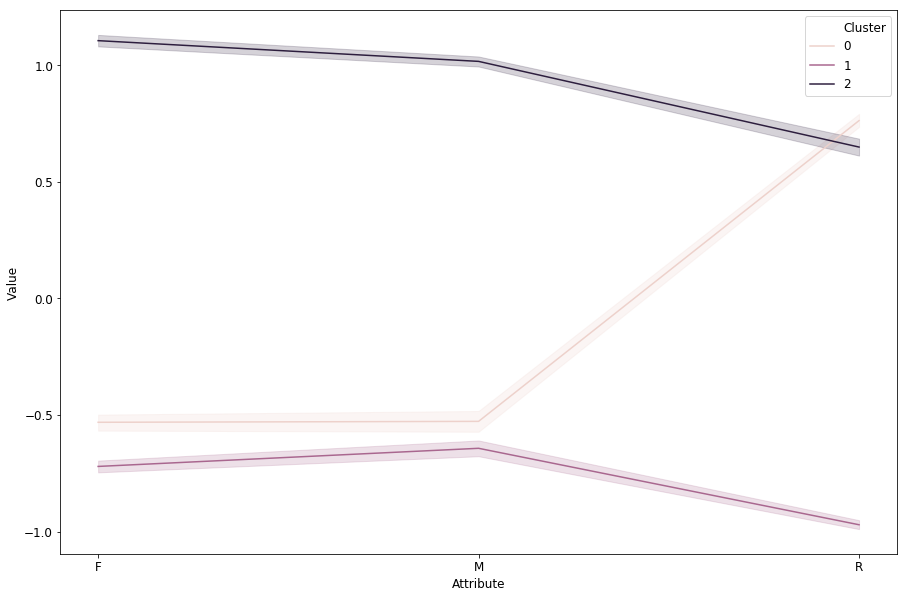

In [101]:
## snake plot to understand and compare segments
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=cust_melt)

In [102]:
# Relative importance of segment attributes
cluster_avg = customer_view.groupby('Cluster')['R','F','M'].mean()

In [103]:
population_avg = customer_view[['R','F','M']].mean()

In [104]:
relative_imp = cluster_avg/population_avg - 1

In [105]:
relative_imp.round(2)

,R,F,M
Cluster,,,
0,0.34,-0.26,-0.24
1,-0.43,-0.35,-0.29
2,0.29,0.54,0.45


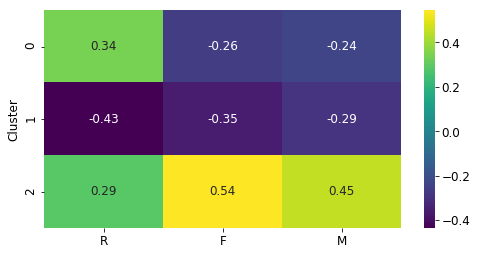

In [106]:
# ploting relative importances
plt.figure(figsize=(8,4))
sns.heatmap(data=relative_imp,annot=True, fmt='.2f', cmap='viridis')

In [107]:
segment_avg = customer_view.groupby('Segment')['R','F','M'].mean()
relative_imp = segment_avg/population_avg - 1

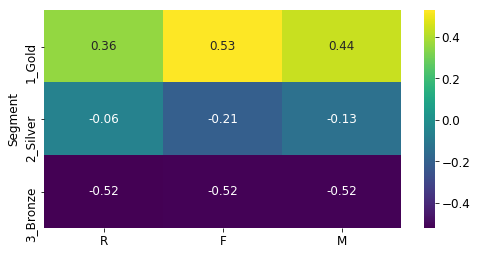

In [108]:
plt.figure(figsize=(8,4))
sns.heatmap(data=relative_imp,annot=True, fmt='.2f', cmap='viridis')

In [109]:
# silhouette_score for cluster evaluation
silhouette_score(customer_view_nor[['R','F','M']], customer_view['Cluster'])

0.4177748974032862

### Agglomerative Clustering
It is bottom up method of hierarchical clustering which is used to group objects in clusters based on their similarity. The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram.

In [110]:
ss = StandardScaler()
ss.fit(customer_view[['R', 'F', 'M']])
customer_view_nor_agg = ss.transform(customer_view[['R', 'F', 'M']])

In [111]:
# agg clustering
agg = AgglomerativeClustering(n_clusters=3, linkage='complete')
agg.fit(customer_view_nor_agg)
customer_view['AggCluster'] = agg.labels_

In [112]:
customer_view.head(5)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment,Cluster,AggCluster
CustomerID,,,,,,,,,,,
12346.0,326,2,0.00,1,2,1,121,4,3_Bronze,1,0
12347.0,2,7,4310.00,4,4,4,444,12,1_Gold,2,2
12348.0,75,4,1437.24,2,3,3,233,8,2_Silver,2,1
12349.0,19,1,1457.55,3,1,3,313,7,2_Silver,0,1
12350.0,310,1,294.40,1,1,2,112,4,3_Bronze,1,1


In [113]:
customer_view.groupby(['AggCluster']).agg({'Recency':np.mean,'Frequency':np.mean,'Monetary':[np.mean,np.size]}).round(0)

Recency Frequency Monetary        
              mean      mean     mean    size
AggCluster                                   
0            125.0       2.0    281.0  1852.0
1            114.0       3.0   1223.0  1361.0
2             13.0      12.0   5287.0  1150.0

In [114]:
customer_view_nor_agg = pd.DataFrame(customer_view_nor_agg,index=customer_view.index,
                                 columns=['R','F','M'])
customer_view_nor_agg['AggCluster'] = customer_view['AggCluster']
customer_view_nor_agg['Segment'] = customer_view['Segment']
customer_view_nor_agg.reset_index(inplace = True)

In [115]:
customer_view_nor_agg.head(5)

,CustomerID,R,F,M,AggCluster,Segment
0,12346.0,-1.344796,-0.293113,-1.341415,0,3_Bronze
1,12347.0,1.321371,1.446823,1.341620,2,1_Gold
2,12348.0,-0.456074,0.576855,0.447275,1,2_Silver
3,12349.0,0.432649,-1.163082,0.447275,1,2_Silver
4,12350.0,-1.344796,-1.163082,-0.447070,1,3_Bronze


In [116]:
## snake plot to understand and compare segments
cust_melt_agg = pd.melt(customer_view_nor_agg, id_vars=['CustomerID','AggCluster','Segment'], 
                    value_vars=['R', 'F', 'M'],
                   var_name='Attribute',
                   value_name='Value')

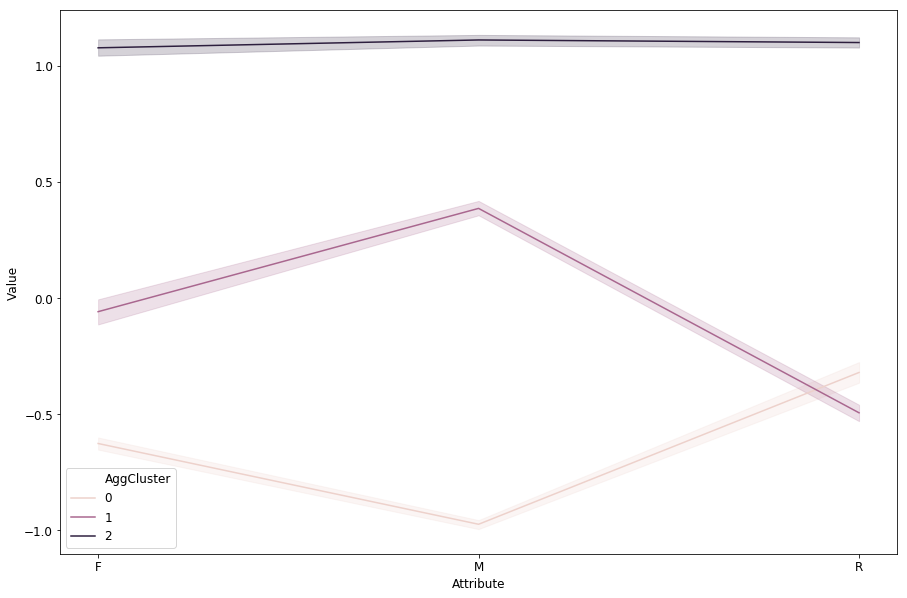

In [117]:
sns.lineplot(x='Attribute', y='Value', hue='AggCluster', data=cust_melt_agg)

C:\Users\ABC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


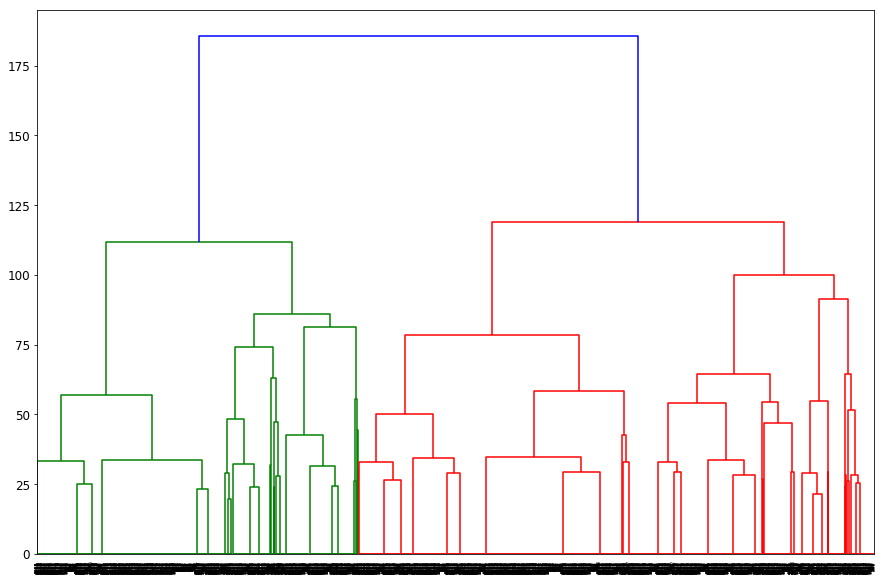

In [118]:
dis_mat = distance_matrix(customer_view_nor_agg[['R','F','M']], customer_view_nor_agg[['R','F','M']])
z = hierarchy.linkage(dis_mat, 'complete')
dendro = hierarchy.dendrogram(z)

In [119]:
silhouette_score(customer_view_nor_agg[['R','F','M']], customer_view['AggCluster'])

0.29101405052463863

### Conclusion
We have compared results from both clustering algorithms. K-Means performed better for clustering the customers considering the  silhouette score. Silhouette score is a way to measure how close each point in a cluster is to the points in its neighboring clusters. For evaluation of clusters, we used silhouette score and snake plot.

### References
* https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
* https://www.datacamp.com/courses/customer-segmentation-in-python
* https://chartio.com/learn/marketing-analytics/what-can-you-do-with-a-cohort-analysis/